### DSC 630 Week  : 
#### Activity 8.2 
#### Author: Brian Reppeto 10/20/2024

###  import libraries

In [75]:
# import libraries

import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [93]:
# load the dataset

df = pd.read_csv('us_retail_sales.csv')

#### Preview the First 15 Rows

In [77]:
# head the data

df.head(15)

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1992,146925,147223,146805,148032,149010,149800,150761.0,151067.0,152588.0,153521.0,153583.0,155614.0
1,1993,157555,156266,154752,158979,160605,160127,162816.0,162506.0,163258.0,164685.0,166594.0,168161.0
2,1994,167518,169649,172766,173106,172329,174241,174781.0,177295.0,178787.0,180561.0,180703.0,181524.0
3,1995,182413,179488,181013,181686,183536,186081,185431.0,186806.0,187366.0,186565.0,189055.0,190774.0
4,1996,189135,192266,194029,194744,196205,196136,196187.0,196218.0,198859.0,200509.0,200174.0,201284.0
5,1997,202371,204286,204990,203399,201699,204675,207014.0,207635.0,208326.0,208078.0,208936.0,209363.0
6,1998,209666,209552,210832,213633,214639,216337,214841.0,213636.0,215720.0,219483.0,221134.0,223179.0
7,1999,223997,226250,227417,229037,231235,231903,233948.0,236566.0,237481.0,237553.0,240544.0,245485.0
8,2000,243436,247133,249825,245831,246201,248160,247176.0,247576.0,251837.0,251221.0,250331.0,250658.0
9,2001,252654,252704,250328,254763,255218,254022,252997.0,254560.0,249845.0,267999.0,260514.0,256549.0


#### Check for missing values in the dataset by summing the null values for each column

In [78]:
# check for nulls

df.isnull().sum()

YEAR    0
JAN     0
FEB     0
MAR     0
APR     0
MAY     0
JUN     0
JUL     1
AUG     1
SEP     1
OCT     1
NOV     1
DEC     1
dtype: int64

#### Fill Missing Values

In [79]:
# fill missing values with mean

df.fillna(df.mean(), inplace=True)

In [80]:
# recheck for missing values after filling with mean

df.isnull().sum()

YEAR    0
JAN     0
FEB     0
MAR     0
APR     0
MAY     0
JUN     0
JUL     0
AUG     0
SEP     0
OCT     0
NOV     0
DEC     0
dtype: int64

#### Transform the dataframe where each year has multiple month columns into a long format where each row represents one month of sales for a particular year

In [81]:
# reshape the data into long format

df_long = df.melt(id_vars=['YEAR'], var_name='Month', value_name='Sales')
df_long['Date'] = pd.to_datetime(df_long['YEAR'].astype(str) + df_long['Month'], format='%Y%b')
df_long = df_long.sort_values('Date')

#### Set the 'Date' column as the index of the df, and convert the index into a period index with a monthly frequency

In [82]:
# set the dat column as the index and define frequency as monthly

df_long.set_index('Date', inplace=True)
df_long.index = df_long.index.to_period('M')

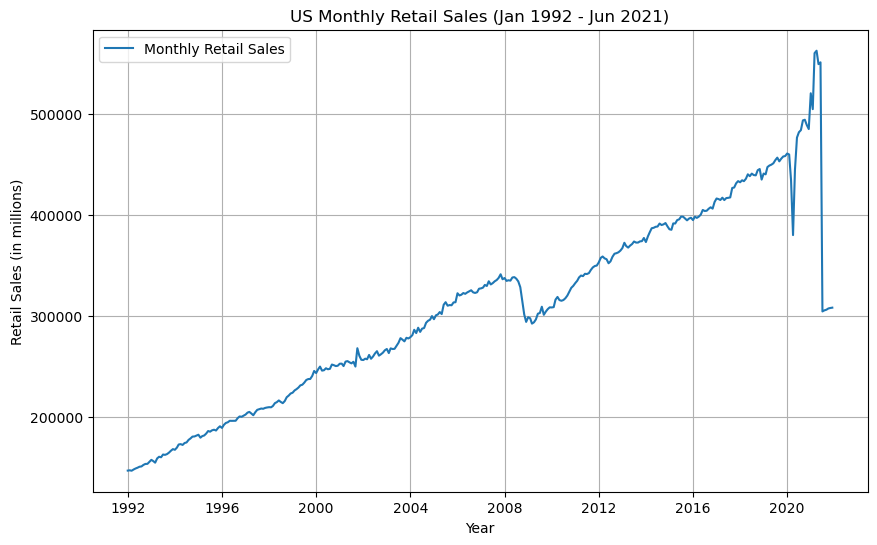

In [91]:
# plot the data

plt.figure(figsize=(10, 6))
plt.plot(df_long.index.to_timestamp(), df_long['Sales'], label='Monthly Retail Sales')
plt.xlabel('Year')
plt.ylabel('Retail Sales (in millions)')
plt.title('US Monthly Retail Sales (Jan 1992 - Jun 2021)')
plt.grid(True)
plt.legend()
plt.show()

The graph shows a general upward trend in monthly retail sales in the US from January 1992 to June 2021. There are noticeable peaks, which typically occur towards the end of each year.  The spikes are likely due to holiday spending late in the year. The trend was stable until the 2008 financial crisis, after which there is a slight dip, followed by anoother recovery. Another notable change occurs in 2020, likely due to the COVID-19 pandemic, where sales initially dip sharply and then recover.

#### Split the dataset into a training set and a test set. The training set will be used to build the predictive model, while the test set will be used to evaluate the accuracy of the model's predictions. The copy method ensures that the original df remains unchanged 

In [84]:
# split the data into training (up to June 2020) and test set (July 2020 - June 2021)

train_data = df_long[df_long.index < '2020-07'].copy()
test_data = df_long[(df_long.index >= '2020-07') & (df_long.index <= '2021-06')].copy()

###  Create a model to predict future sales by recognizing patterns in past data, like seasonal changes and overall trends

In [86]:
# build a predictive model using holt winters

hw_model = ExponentialSmoothing(train_data['Sales'], seasonal='add', trend='add', seasonal_periods=12, use_boxcox=True).fit(optimized=True, remove_bias=True)

In [87]:
# predict the monthly retail sales for the last year

hw_predictions = hw_model.forecast(steps=len(test_data))

In [88]:
# report the RMSE of the model predictions on the test set

hw_rmse = np.sqrt(mean_squared_error(test_sales, hw_predictions))
print(f"Holt-Winters RMSE: {hw_rmse}")

Holt-Winters RMSE: 45306.78927223505
